In [1]:
import easyesn 
from easyesn import backend as B
import numpy as np
import torch
import h5py
from esn_fun import ImportData, NormalizeData, PreparePredictorData, RunESNWithParams, ConvertNumpyToTorch
from esn_params import ESNParams

#Check easyesn backend 
usingTorch = B._backend == "torch"

path_data = '/home/flhe/Documents/hdf5/'
filename_data = 'Lorenz63.hdf5'
filepath_data = path_data + filename_data

path_esn = '/home/flhe/Documents/hdf5/'      
filename_esn = 'Lorenz63_esn.hdf5'
filepath_esn = path_esn + filename_esn
###################################### 

#Study Params (#adapt member function correspodning to study_parameters in line 308)
randomSeed = 0
#nseed = len(randomSeed)
#study_parameters = (np.linspace(0,1.2,401, endpoint = True),)
study_parameters = ([2100],)
nstudyparameters = len(study_parameters)

#----------------------------------
#DATA PARAMETERS
#----------------------------------
norm = "abs_max"
data = ImportData(filepath_data)
data = NormalizeData(data,norm)
n_input_data = data.shape[1]
data_timesteps = data.shape[0]                           #no. time steps the orignal data has/should have

trainingLength = 2000                            #no. time steps for the training data set
testingLength = 1000                             #no. time stes for the testing/validation data set
esn_timesteps = trainingLength + testingLength  #no. total resulting time steps for the esn 

#To DO: for now this only works if esn_start != 0
esn_start = data_timesteps - esn_timesteps      #Index of the original data, at which the training output y_train will begin. 
                                                #Note that the training input u_train will therefore begin at the index esn_start-1. esn_start therefore must not be 0!
esn_end = data_timesteps                        #Index of the original data, at which the testing/validation output y_test will end.

#----------------------------------
#RESERVOIR PARAMETERS
#----------------------------------

n_input = n_input_data                           #input data dimensions
n_output =  n_input_data                         #output data dimensions
n_reservoir = 2100                               #dimensions of reservoir state and W with shape (n_reservoir, n_reservoir)
leakingRate = 0.95                               #factor controlling the leaky integrator formulation (1 -> fully nonlinear, 0 -> fully linear)
spectralRadius = 0.95                            #maximum absolute eigenvalue of W
regressionParameters = [5e-2]                    #ridge regression/ penalty parameter of ridge regression
reservoirDensity = 0.2                           #fraction of non-zero elements of W
noiseLevel = 0#1e-6                              #amplitude of the gaussian noise term in the activation function
inputScaling = 1.0                               #
inputDensity = 1.0                               #fraction of non-zero elements of Win
solver = 'lsqr'                                  #method the training/fitting procedure should use to compute Wout
weightGeneration = 'naive'                       #method the random weights Win, W should be initialized.
feedback = False                                 #
bias = 1.0                                       #input bias in the input mapping: Win*[1;u]
outputBias = 1.0                                 #output bias in the final output mapping:  y = Wout*[outputbias; outputInputScaling*u; s]
outputInputScaling = 1.0                         #factor by which the input data should be scaled by in the final output mapping: y = Wout*[outputbias; outputInputScaling*u; s]
transientTime = "Auto"
transientTimeCalculationLength = 20              #
transientTimeCalculationEpsilon = 1e-3           #
p = 1                                            #Prediction time steps. For now: only p=1 is valid. TO DO: implement more general case.
################

#Construct training & testing/validation data from original data.
u_train, y_train, u_test, y_test = PreparePredictorData(data, n_input, n_output, trainingLength, testingLength, esn_start, esn_end)


esn_params = ESNParams(randomSeed,
                esn_start, esn_end,
                trainingLength, testingLength,
                data_timesteps,
                n_input,n_output,n_reservoir,
                leakingRate, spectralRadius,
                reservoirDensity, regressionParameters,
                bias,outputBias, outputInputScaling,
                inputScaling, inputDensity, noiseLevel,
                weightGeneration, solver, feedback,
                p, transientTime, transientTimeCalculationEpsilon,transientTimeCalculationLength)

esn_params.SetTrainingData(u_train, y_train)
esn_params.SetTestingData(y_test,y_train[-1,:])

#Convert all numpy arrays of the ESNParams class object to torch tensors
if usingTorch:
    ConvertNumpyToTorch(esn_params)       

Using Torch backend.
Using device `cpu` as specified by config

## Show Training & Testing/Validation data

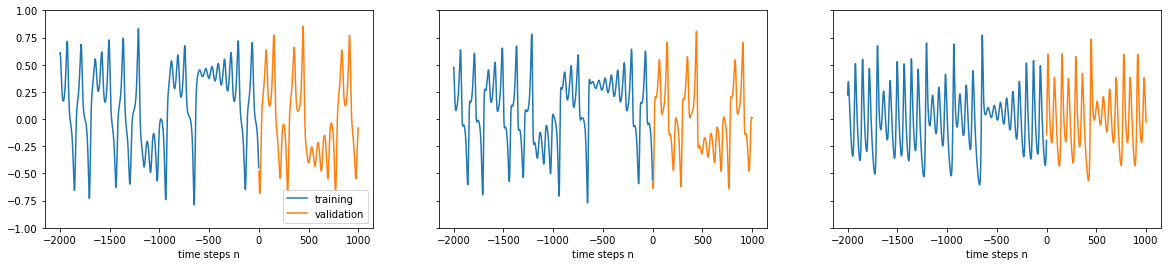

In [2]:
import matplotlib.pyplot as plt

fig,axs = plt.subplots(figsize=(20,4), ncols = 3, sharey = True)

ii = 0
for imode in range(n_input):
    axs[ii].plot(np.arange(-trainingLength,0,1), y_train[:,imode], label = 'training')
    axs[ii].plot(np.arange(1,testingLength+1,1), y_test[:,imode], label = 'validation')
    axs[ii].set_ylim([-1,1])    
    axs[ii].set_xlabel('time steps n')
    ii +=1

axs[0].legend(loc = 'lower right')


## Run One ESN

In [3]:
torch.manual_seed(randomSeed)
esn_params.randomSeed = None
mse_train, mse_test, y_pred = RunESNWithParams(esn_params)

#NRMSE 
nrmse_train = np.sqrt(mse_train) / torch.std(esn_params.y_train)
nrmse_test = np.sqrt(mse_test) / torch.std(esn_params.y_test)

print("NRMSE in testing phase is {0:.2e}".format(nrmse_test))

Thread 0: Building ESN Model
Thread 0: Fitting ESN Model

Thread 0: Predicting reservoir outputs


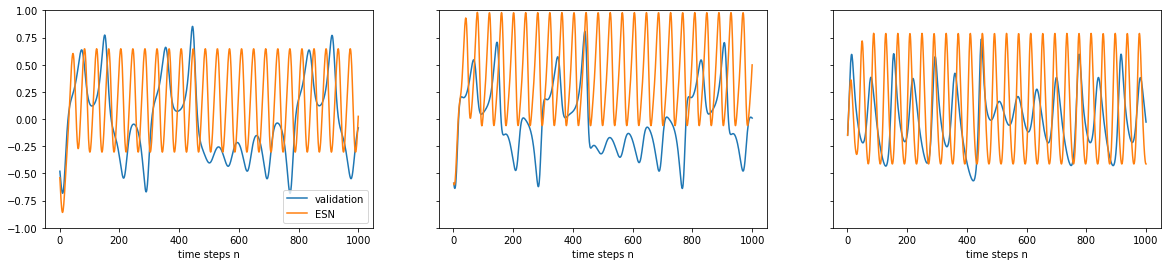

In [14]:
import matplotlib.pyplot as plt

fig,axs = plt.subplots(figsize=(20,4), ncols = 3, sharey = True)

ii = 0
for imode in range(n_input):
    axs[ii].plot(np.arange(1,testingLength+1,1), y_test[:,imode], label = 'validation')
    axs[ii].plot(np.arange(1,testingLength+1,1), y_pred[:,imode], label = 'ESN')
    
    axs[ii].set_ylim([-1,1])    
    axs[ii].set_xlabel('time steps n')
    ii +=1

axs[0].legend(loc = 'lower right')
